[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/neurogym/ngym_usage/blob/master/supervised/auto_notebooks/supervised/PerceptualDecisionMaking-v0.ipynb)

### Training a Recurrent Neural Network

In this tutorial, we will train a Recurrent Neural Network (RNN) on a two-alternative forced choice task in which the network must integrate two stimuli to decide which one is higher on average.

### Install Neurogym

We will use the toolbox [**Neurogym**](https://github.com/neurogym/neurogym/) to define the tasks that our RNNs will have to learn. 
**NeuroGym** is a curated collection of neuroscience tasks with a common interface whose main goal is to facilitate training of neural network models on neuroscience tasks.

In [186]:
# Uncomment following lines to install
# ! pip install gym   # Install gym
# ! git clone https://github.com/gyyang/neurogym.git  # Install neurogym
# %cd neurogym/
# ! pip install -e .

### Imports

Import the packages we need for training and analyzing the RNNs. Especially, we will use the toolbox [pytorch](https://pytorch.org/) to define and train the networks.

In [187]:
# packages to save data
import os
from pathlib import Path
import json
# packages to handle data
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
# packages to visualize data
import matplotlib.pyplot as plt

# import torch and neural network modules to build RNNs
import torch
import torch.nn as nn

# import gym and neurogym to create tasks
import gym
import neurogym as ngym
from neurogym.utils import plotting
# check if GPU is available
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# name of the task on the neurogym library
envid = 'PerceptualDecisionMaking-v0'

### Auxiliary functions

We need to create a path to save the data from the network that we will analize.

In [188]:
def get_modelpath(envid):
    # Make a local file directories
    path = Path('.') / 'files'
    os.makedirs(path, exist_ok=True)
    path = path / envid
    os.makedirs(path, exist_ok=True)
    return path

And a function to infer the periods of the task

In [189]:
def infer_test_timing(env):
    """Infer timing of environment for testing."""
    timing = {}
    for period in env.timing.keys():
        period_times = [env.sample_time(period) for _ in range(100)]
        timing[period] = np.median(period_times)
    return timing

### Training parameters

In [190]:
# Set up config:
# dt: time step in ms
# batch_size: number of trials per batch
# lr: learning rate
# seq_len: number of time steps for the gradient update
training_kwargs = {'dt': 100, 'lr': 1e-2, 'batch_size': 16,
                   'seq_len': 100, 'envid': envid}

### Define task

In [191]:
def get_dataset(env_kwargs, training_kwargs):
    # Make supervised dataset using neurogym's Dataset class
    dataset = ngym.Dataset(envid, env_kwargs=env_kwargs, batch_size=training_kwargs['batch_size'],
                       seq_len=training_kwargs['seq_len'])
    env = dataset.env
    return dataset, env

##### Task's parameters

In [192]:
# Set up task parameters
# timing: duration of each trial period in ms
# rewards: reward values for correct, abort (fixation break), and fail trials
# sigma: standard deviation of the Gaussian noise
# dim_ring: number of stimuli / choices
env_kwargs = {'dt': training_kwargs['dt'],
              'timing': {'fixation': 200, 'stimulus': 2000, 'delay': 0, 'decision': 200},
              'rewards': {'abort': -0.1, 'correct': +1., 'fail': 0.},
              'sigma': 1.0,
              'dim_ring': 2}
dataset, env = get_dataset(env_kwargs=env_kwargs, training_kwargs=training_kwargs)

##### Plot task

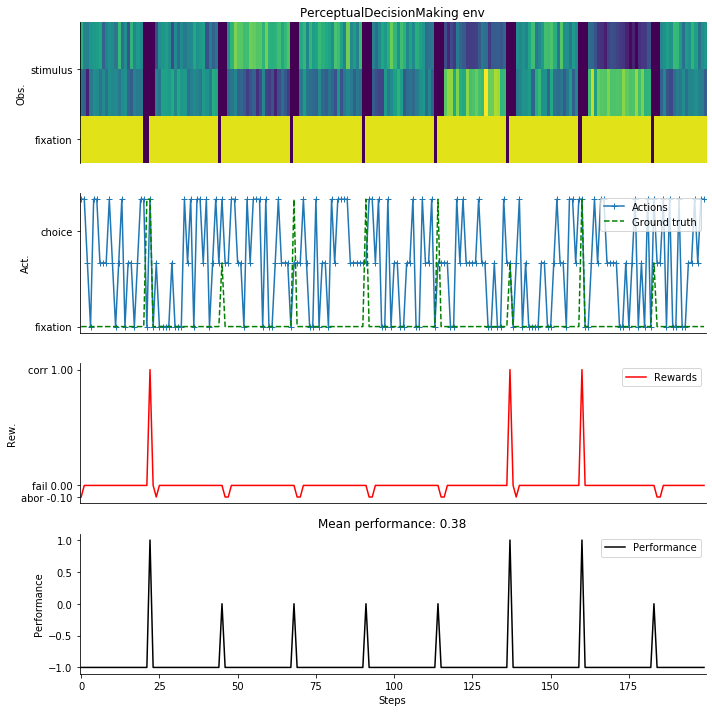

In [193]:
# Plot several trials of the task with a random agent
f = plotting.plot_env(env, fig_kwargs={'figsize': (10, 10)})

### Define network

In [194]:
class Net(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(Net, self).__init__()
        # INSTRUCTION 1: build a recurrent neural network with a single recurrent layer and reactified linear units
        self.vanilla = nn.RNN(input_size, hidden_size, nonlinearity='relu')
        self.linear = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        # INSTRUCTION 2: get the output of the network for a given input
        out, _ = self.vanilla(x)
        x = self.linear(out)
        return x, out


##### Network's parameters

In [195]:
# Get path to save model data
modelpath = get_modelpath(envid)
# Set up config:
num_neurons = 64
act_size = env.action_space.n
net_kwargs = {'hidden_size': num_neurons,
              'action_size': act_size,
              'input_size': env.observation_space.shape[0]}
# Define network
net = Net(input_size=env.observation_space.shape[0],
          hidden_size=net_kwargs['hidden_size'],
          output_size=act_size)
net = net.to(device)
# Define loss
criterion = nn.CrossEntropyLoss()
# Define optimizer
optimizer = torch.optim.Adam(net.parameters(), lr=training_kwargs['lr'])

### Save config

In [196]:
training_kwargs['env_kwargs'] = env_kwargs
training_kwargs['net_kwargs'] = net_kwargs

# Save config
with open(modelpath / 'config.json', 'w') as f:
    json.dump(training_kwargs, f)

### Supervised training of network

[Explanation of training](https://pytorch.org/tutorials/beginner/blitz/neural_networks_tutorial.html#define-the-network).

[Clarifications regarding zero_grad](https://discuss.pytorch.org/t/model-zero-grad-or-optimizer-zero-grad/28426).

[Clarifications regarding why we can make a forward pass calling net](https://discuss.pytorch.org/t/about-the-nn-module-forward/20858).

In [197]:
print('Training task ', envid)
num_epochs = 2000
running_loss = 0.0
for i in range(num_epochs):
    # get inputs and labels
    inputs, labels = dataset()
    inputs = torch.from_numpy(inputs).type(torch.float).to(device)
    labels = torch.from_numpy(labels.flatten()).type(torch.long).to(device)
    # zero the parameter gradients to avoid they accumulate
    optimizer.zero_grad()

    # INSTRUCTION 3: get the output of the network for a given input
    outputs, _ = net(inputs)
    #reshape outputs
    outputs = outputs.view(-1, act_size)
    #  INSTRUCTION 4: compute loss with respect to the labels
    loss = criterion(outputs, labels)
    # INSTRUCTION 5: compute gradients
    loss.backward()
    # INSTRUCTION 6: update weights
    optimizer.step()

    # print statistics
    running_loss += loss.item()
    if i % 200 == 199:
        print('{:d} loss: {:0.5f}'.format(i + 1, running_loss / 200))
        running_loss = 0.0
        # save current state of network's parameters
        torch.save(net.state_dict(), modelpath / 'net.pth')

print('Finished Training')

Training task  PerceptualDecisionMaking-v0
200 loss: 0.11904
400 loss: 0.05650
600 loss: 0.05646
800 loss: 0.04432
1000 loss: 0.03771
1200 loss: 0.03545
1400 loss: 0.03414
1600 loss: 0.03084
1800 loss: 0.03170
2000 loss: 0.03130
Finished Training


### Run network after training for analysis

[About tensor.detach](https://www.tutorialspoint.com/what-does-tensor-detach-do-in-pytorch)

In [207]:
modelpath = get_modelpath(envid)
with open(modelpath / 'config.json') as f:
    config = json.load(f)

env_kwargs = config['env_kwargs']
net_kwargs = config['net_kwargs']
# Run network to get activity and info
# Environment
env = gym.make(envid, **env_kwargs)
env.timing = infer_test_timing(env)
env.reset(no_step=True)

# Instantiate the network and print information
with torch.no_grad():
    net = Net(input_size=net_kwargs['input_size'],
              hidden_size=net_kwargs['hidden_size'],
              output_size=net_kwargs['action_size'])
    net = net.to(device)
    # load the trained network's parameters from the saved file
    net.load_state_dict(torch.load(modelpath / 'net.pth'))

    perf = 0
    num_trial = 100
    activity = list()
    obs = list()
    info = pd.DataFrame()
    for i in range(num_trial):
        env.new_trial()
        ob, gt = env.ob, env.gt
        inputs = torch.from_numpy(ob[:, np.newaxis, :]).type(torch.float)
        # INSTRUCTION 7: get the network's prediction for the current input
        action_pred, hidden = net(inputs)
        # Compute performance
        action_pred = action_pred.detach().numpy()
        # INSTRUCTION 8: get the network's choice
        choice = np.argmax(action_pred[-1, 0, :])
        # INSTRUCTION 9: check if the choice is correct
        correct = choice == gt[-1]

        # Log trial info
        trial_info = env.trial
        trial_info.update({'correct': correct, 'choice': choice})
        info = info.append(trial_info, ignore_index=True)
        # Log activity
        activity.append(np.array(hidden)[:, 0, :])
        # Log observations
        obs.append(ob)

    print('Average performance', np.mean(info['correct']))

activity = np.array(activity)
# print stats of the activity: max, min, mean, std
print('Max: ' + str(np.max(activity)) + ', Min: ' + str(np.min(activity)) + ', Mean: ' + str(np.mean(activity)) + ', Std: ' + str(np.std(activity)))
obs = np.array(obs)


Average performance 0.89
Max: 1.0, Min: -1.0, Mean: 0.0017090247, Std: 0.88658947


### General analysis

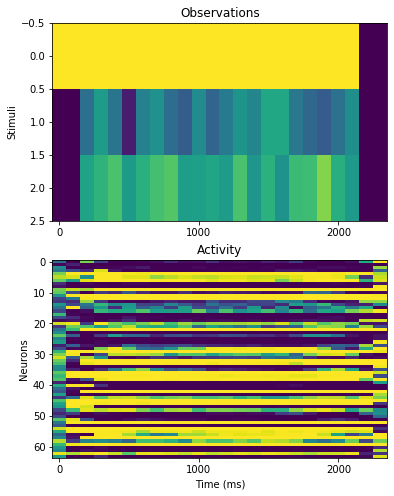

In [199]:
def plot_activity(activity, obs, config):
    # Load and preprocess results
    f, ax = plt.subplots(figsize=(6, 8), nrows=2)
    t_plot = np.arange(activity.shape[1]) * config['dt']
    ax[0].imshow(obs[0, :, :].T, aspect='auto')
    ax[0].set_title('Observations')
    ax[0].set_ylabel('Stimuli')
    # change the xticks to show time in ms
    ax[0].set_xticks(np.arange(0, activity.shape[1], 10))
    ax[0].set_xticklabels(t_plot[::10])
    ax[1].imshow(activity[0, :, :].T, aspect='auto', cmap='viridis')
    ax[1].set_title('Activity')
    ax[1].set_xlabel('Time (ms)')
    ax[1].set_ylabel('Neurons')
    # change the xticks to show time in ms
    ax[1].set_xticks(np.arange(0, activity.shape[1], 10))
    ax[1].set_xticklabels(t_plot[::10])
plot_activity(activity=activity, obs=obs, config=config)

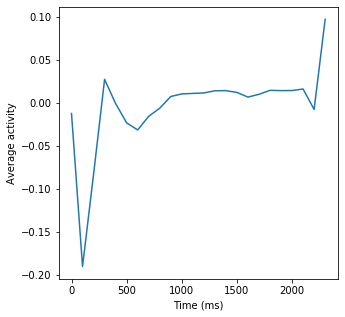

In [200]:
def analysis_average_activity(activity, config):
    # Load and preprocess results
    f, ax = plt.subplots(figsize=(5, 5))
    t_plot = np.arange(activity.shape[1]) * config['dt']
    ax.plot(t_plot, activity.mean(axis=0).mean(axis=-1))
    ax.set_xlabel('Time (ms)')
    ax.set_ylabel('Average activity')

analysis_average_activity(activity, config)

In [201]:
def get_conditions(info):
    """Get a list of task conditions to plot."""
    conditions = info.columns
    # This condition's unique value should be less than 5
    new_conditions = list()
    for c in conditions:
        try:
            n_cond = len(pd.unique(info[c]))
            if 1 < n_cond < 5:
                new_conditions.append(c)
        except TypeError:
            pass

    return new_conditions


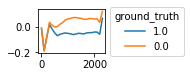

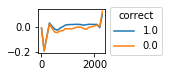

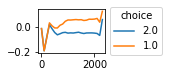

In [202]:
def analysis_activity_by_condition(activity, info, config):
    conditions = get_conditions(info)
    for condition in conditions:
        values = pd.unique(info[condition])
        plt.figure(figsize=(1.2, 0.8))
        t_plot = np.arange(activity.shape[1]) * config['dt']
        for value in values:
            a = activity[info[condition] == value]
            plt.plot(t_plot, a.mean(axis=0).mean(axis=-1), label=str(value))
        plt.legend(title=condition, loc='center left', bbox_to_anchor=(1.0, 0.5))

analysis_activity_by_condition(activity, info, config)

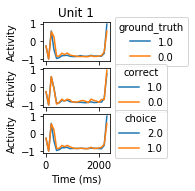

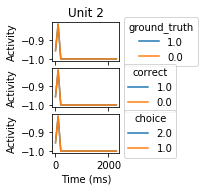

In [203]:
def analysis_example_units_by_condition(activity, info, config):
    conditions = get_conditions(info)
    if len(conditions) < 1:
        return

    example_ids = np.array([0, 1])
    for example_id in example_ids:
        example_activity = activity[:, :, example_id]
        fig, axes = plt.subplots(
                len(conditions), 1,  figsize=(1.2, 0.8 * len(conditions)),
                sharex=True)
        for i, condition in enumerate(conditions):
            ax = axes[i]
            values = pd.unique(info[condition])
            t_plot = np.arange(activity.shape[1]) * config['dt']
            for value in values:
                a = example_activity[info[condition] == value]
                ax.plot(t_plot, a.mean(axis=0), label=str(value))
            ax.legend(title=condition, loc='center left', bbox_to_anchor=(1.0, 0.5))
            ax.set_ylabel('Activity')
            if i == len(conditions) - 1:
                ax.set_xlabel('Time (ms)')
            if i == 0:
                ax.set_title('Unit {:d}'.format(example_id + 1))

analysis_example_units_by_condition(activity, info, config)

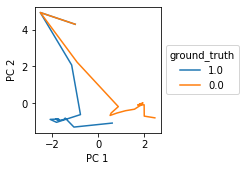

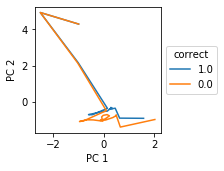

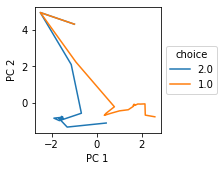

In [204]:
def analysis_pca_by_condition(activity, info, config):
    # Reshape activity to (N_trial x N_time, N_neuron)
    activity_reshape = np.reshape(activity, (-1, activity.shape[-1]))
    pca = PCA(n_components=2)
    pca.fit(activity_reshape)

    conditions = get_conditions(info)
    for condition in conditions:
        values = pd.unique(info[condition])
        fig = plt.figure(figsize=(2.5, 2.5))
        ax = fig.add_axes([0.2, 0.2, 0.7, 0.7])
        for value in values:
            # Get relevant trials, and average across them
            a = activity[info[condition] == value].mean(axis=0)
            a = pca.transform(a)  # (N_time, N_PC)
            plt.plot(a[:, 0], a[:, 1], label=str(value))
        plt.legend(title=condition, loc='center left', bbox_to_anchor=(1.0, 0.5))

        plt.xlabel('PC 1')
        plt.ylabel('PC 2')

analysis_pca_by_condition(activity, info, config)